import packages

In [1]:
import pandas as pd
import xarray as xr
from sklearn.metrics import r2_score
import cartopy.crs as ccrs
import matplotlib.pyplot as plt 
from matplotlib.transforms import offset_copy
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


load data to analyse and set constants (lat/lon coordinates for the in-situ data)

In [2]:
ds_day = pd.read_csv("Datasets\GBB\GBB_ASTER_match_day.csv")
ds_night = pd.read_csv("Datasets\GBB\GBB_ASTER_match_night.csv")
ds_sample = xr.open_dataset("Datasets\GBB\ASTER_OE_sample_output_20121016.nc")

GBB_Wind_lat = -23.550960
GBB_Wind_lon = 15.051390

convert the julian times with pandas

In [3]:
ds_day['Datetime'] = pd.to_datetime(ds_day['Datetime'],origin='julian', unit='D')
ds_night['Datetime'] = pd.to_datetime(ds_night['Datetime'],origin='julian', unit='D')


combine day and night data into single dataframe for statistical analsysis

In [4]:
ds_merged = pd.concat([ds_day,ds_night])
       

calculate the r^2 score

In [5]:
 
oe_vs_insitu_r2 = r2_score(ds_merged["GBB"].values, ds_merged["ASTER"].values)
metric=f"$R^2$ = {oe_vs_insitu_r2:.3f}"

Figure 7 code below:

Text(0.05, 0.85, '$R^2$ = 0.963')

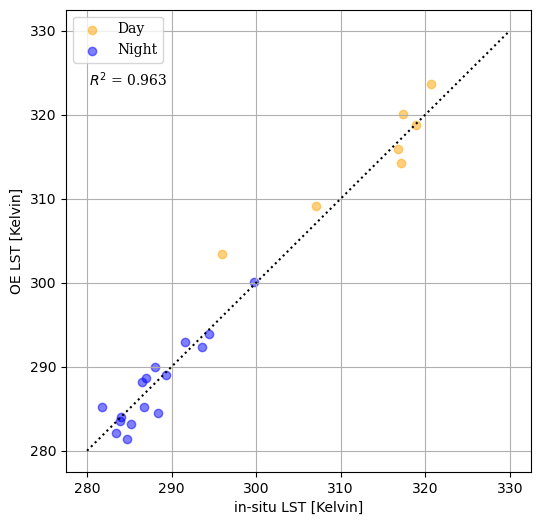

In [6]:
fig, ax = plt.subplots(figsize=(6,6))
plt.rcParams["font.family"] = "Serif"
day = ax.scatter(x=ds_day["GBB"].values,y=ds_day["ASTER"].values,color="Orange",alpha=0.5, label=f"Day")
night = ax.scatter(x=ds_night["GBB"].values,y=ds_night["ASTER"].values,color="Blue",alpha=0.5, label=f"Night")
ax.plot([280,330],[280,330],linestyle="dotted",color="black")
ax.set_ylabel("OE LST [Kelvin]")
ax.set_xlabel("in-situ LST [Kelvin]")
ax.grid(True)
ax.legend(handles=[day,night])
ax.text(0.05,0.85,metric, horizontalalignment='left', verticalalignment='center',transform=ax.transAxes)

Figure 6 code below:

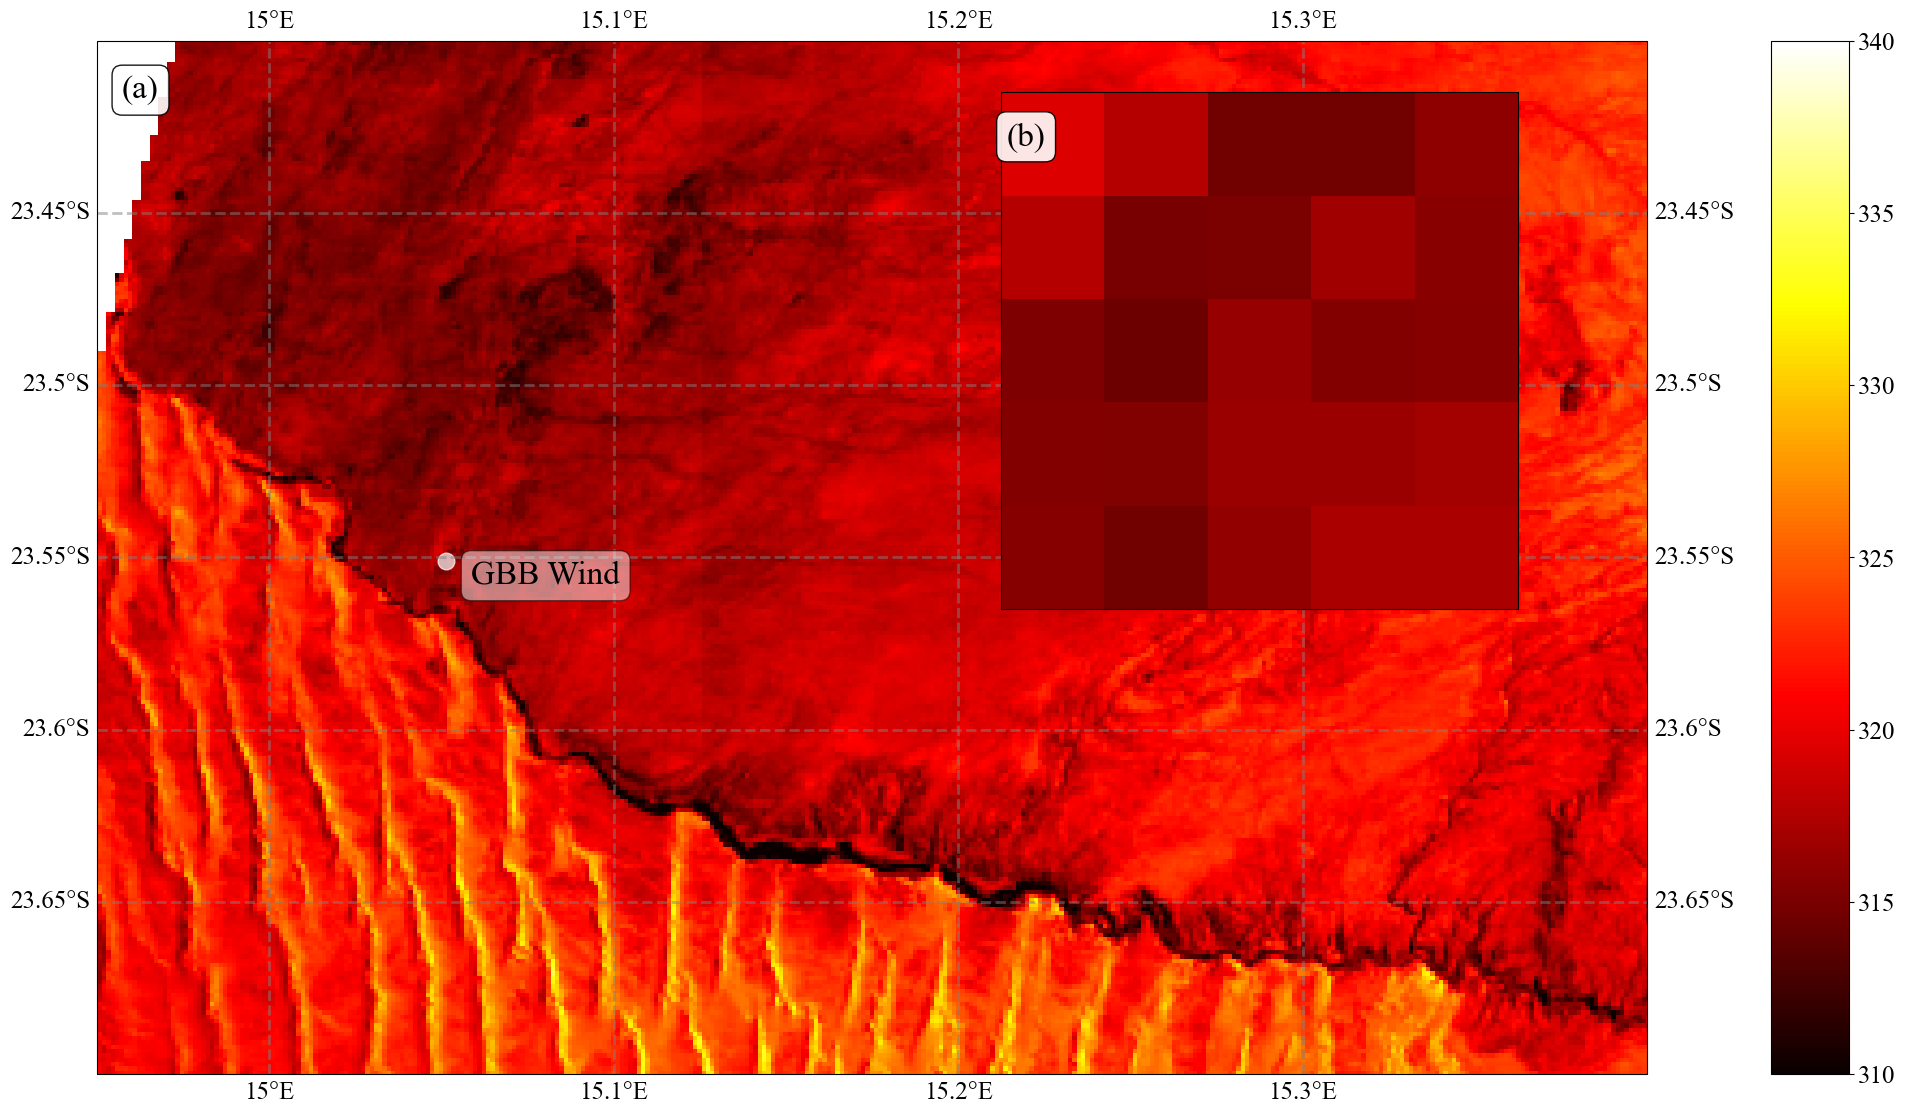

In [7]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams["mathtext.default"] = "regular"

fig, ax = plt.subplots(
    1, 1, figsize=(20, 15), subplot_kw={"projection": ccrs.PlateCarree()}
)
ax.set_extent([14.95, 15.4, -23.7, -23.4], crs=ccrs.PlateCarree())

main = ds_sample.lst.plot(
    ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, cmap="hot",vmin=310,vmax=340, label ="LST [K]"
)  # ,add_labels=False)
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=2,
    color="gray",
    alpha=0.5,
    linestyle="--",
)
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
ax.plot(
    GBB_Wind_lon,
    GBB_Wind_lat,
    marker="o",
    color="white",
    markersize=12,
    alpha=0.7,
    transform=ccrs.Geodetic(),
)

geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
text_transform = offset_copy(geodetic_transform, units="dots", x=25)
ax.text(
    GBB_Wind_lon,
    GBB_Wind_lat,
    "GBB Wind",
    size=24,
    verticalalignment="top",
    horizontalalignment="left",
    transform=text_transform,
    bbox=dict(facecolor="white", alpha=0.5, boxstyle="round"),
)
ax.text(
    14.95,
    -23.41,
    "(a)",
    size=24,
    verticalalignment="top",
    horizontalalignment="left",
    transform=text_transform,
    bbox=dict(facecolor="white", alpha=0.9, boxstyle="round"),
)

inset_x = 0.75
inset_y = 0.7
inset_size = 0.5

ax2 = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

sub = ds_sample.lst.sel(
    lat=slice(GBB_Wind_lat - 0.003, GBB_Wind_lat + 0.003),
    lon=slice(GBB_Wind_lon - 0.002, GBB_Wind_lon + 0.004),
).plot(ax=ax2, transform=ccrs.PlateCarree(), add_colorbar=False, cmap="hot",vmin=310,vmax=340)
geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax2)
text_transform = offset_copy(geodetic_transform, units="dots", x=25)
ax2.text(
    GBB_Wind_lon-0.0025,
    GBB_Wind_lat+0.003,
    "(b)",
    size=24,
    verticalalignment="top",
    horizontalalignment="left",
    transform=text_transform,
    bbox=dict(facecolor="white", alpha=0.9, boxstyle="round"),
)

ip = InsetPosition(
    ax, [inset_x - inset_size / 2, inset_y - inset_size / 2, inset_size, inset_size]
)
ax2.set_axes_locator(ip)

cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="100%",  # height : 50%
                 loc='upper left',
                 bbox_to_anchor=(1.08, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
cb = fig.colorbar(main, cax=cax)
cb.ax.tick_params(labelsize=18)